In [96]:
import numpy as np
import cond_color
import pprint
from matplotlib import pyplot as plt
import seaborn as sns
import random
import tools
from ex1 import plot_neurons

In [97]:
data = np.load('psths.npz')

X = data['X'] # NxCxT
N,C,T = np.shape(X)
times = data['times']

test = np.load('test.npz')
Z_test = test['Z_test']
A_test = test['A_test']

start = np.where(times == -150)[0][0]
end = np.where(times == 300)[0][0] + 1
print(start,end)


65 111


neuron shape:(108, 130)
neuron shape:(108, 130)
neuron shape:(108, 130)
neuron shape:(108, 130)
neuron shape:(108, 130)


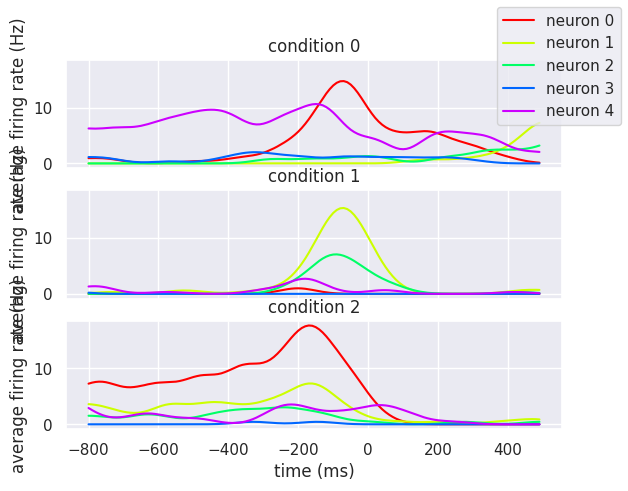

In [98]:
## CONTROL MEASURE ## 
control = False

if control:
    for n in range(N):
        c_is = np.random.choice(C, (C//2))
        for c in c_is:
            X[n,c,start:T] = 2 * X[n,c,start] - X[n,c,start:T]


plot_neurons(X,times,num_neurons=5,num_conditions=3)

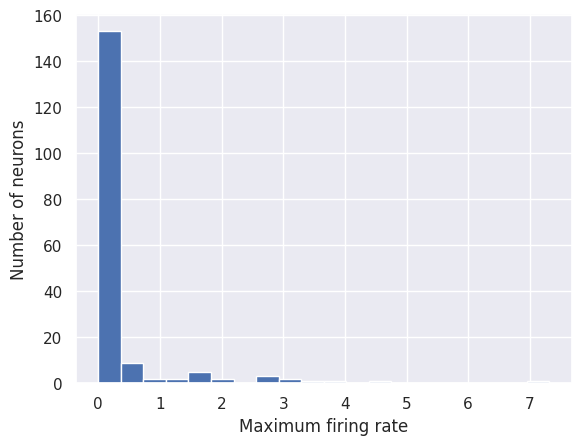

In [99]:
maximums = np.max(X, axis = (1,2))
minimums = np.min(X,axis=(1,2))
plt.hist(minimums,bins=20)
plt.xlabel('Maximum firing rate')
plt.ylabel('Number of neurons')
plt.show()

In [100]:
a, b = maximums,minimums
a = np.reshape(a,(N,1,1))
b = np.reshape(b,(N,1,1))

X = (X-b) / (a-b+5)

cross_condition_mean = np.mean(X,axis=1)
cross_condition_mean = np.reshape(cross_condition_mean,shape=(N,1,T))
X = X - cross_condition_mean


46
(12, 108, 46)
(2, 108, 46)


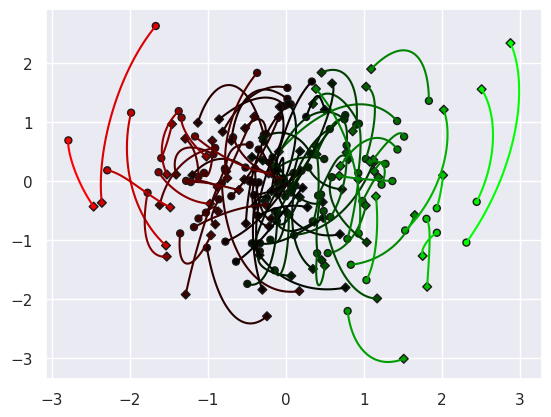

In [ ]:
newtimes = times[start:end]

X_slice = X[:,:,start:end]
T = end - start #46

print(T)
X_slice = np.reshape(X_slice,(N,C*T))

M = 12

S_hat = ( 1/T ) * (X_slice @ X_slice.T)
S_hat.shape

eigenvalues, eigenvectors = np.linalg.eig(S_hat)
sorted_indices = np.argsort(eigenvalues)[::-1]

V_M = eigenvectors[:, sorted_indices[:M]]
np.save('./V',V_M)

Z = V_M.T @ X_slice


test = False
if test:
    Z = Z_test

print(Z.shape)

pc1_pc2 = Z[:2]
pc1_pc2 = np.reshape(pc1_pc2,(2,C,T))
print(pc1_pc2.shape)

def plot_data(plane,show=True,alt_colours=False,alpha=1):
    initial_points = plane[:,:,0]
    final_points = plane[:,:,-1]
    colours = cond_color.get_colors(initial_points[0,:],initial_points[1,:],alt_colors=alt_colours)
    cond_color.plot_start(initial_points[0,:],initial_points[1,:],colors=colours,markersize=100)
    cond_color.plot_end(final_points[0,:],final_points[1,:],colors=colours,markersize=20)


    for i in range(C):
        positions = plane[:,i,:]
        x = positions[0]
        y = positions[1]
        plt.plot(x,y,c=colours[i],alpha=alpha)
    if show:
        plt.show()

plot_data(pc1_pc2)
# cols of V_M are the eigenvectors of S_hat of top M eigenvalues


In [102]:

Z = Z.reshape((M,C,T))

delta_Z = Z[:,:,1:] - Z[:,:,:-1]
delta_Z = delta_Z.reshape((M,C*(T-1)))


Z_slice = Z[:,:,:-1]
Z_slice = Z_slice.reshape((M,C*(T-1)))

#A_mle = ( Z_slice @ delta_Z.T ) / (Z_slice @ Z_slice.T)



In [103]:


K = int((M**2 - M ) / 2)

H = np.zeros((K,M,M))

def generate_vector(K, n):
    vector = np.zeros(K)
    if 0 <= n < K:
        vector[n] = 1
    return vector

position = 0
for i in range(M):
    for j in range(M):
        if i == j:
            H[:,i,j] = np.zeros(K)
        elif j > i:
            
            H[:,i,j] = (generate_vector(K,position))
            position += 1

H = H - np.transpose(H,axes=(0,2,1))



In [104]:

# testing it .. 
def beta_to_A(beta,H):
    # beta = np.array([17,18,19,20,21,22])
    A = np.tensordot(beta, H, axes=1)
    return A


(12, 12)


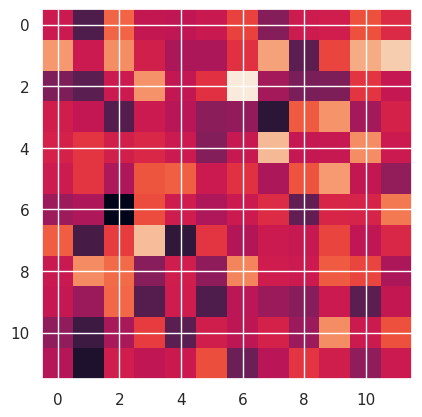

In [105]:

# grad LLH 

W = np.tensordot(H, Z_slice, axes=1)

W_T = np.transpose(W,(1,2,0))

b = np.tensordot(W, delta_Z,axes=2)

Q = np.tensordot(W,W_T,axes=2)

beta = np.linalg.solve(Q,b)

A = beta_to_A(beta,H)
print(A.shape)
plt.imshow(A)

2.6940862735136406e-12


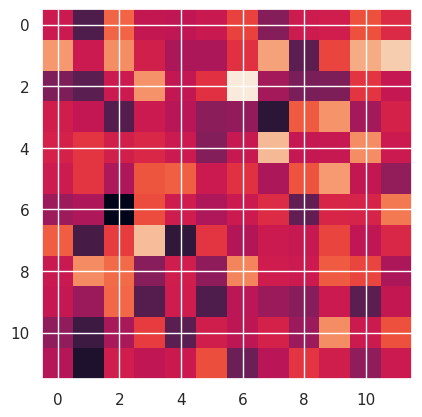

In [106]:


print(np.max(np.abs(A - A_test)))
plt.imshow(A_test)




[ 0  2  4  6  8 10 11  9  7  5  3  1]


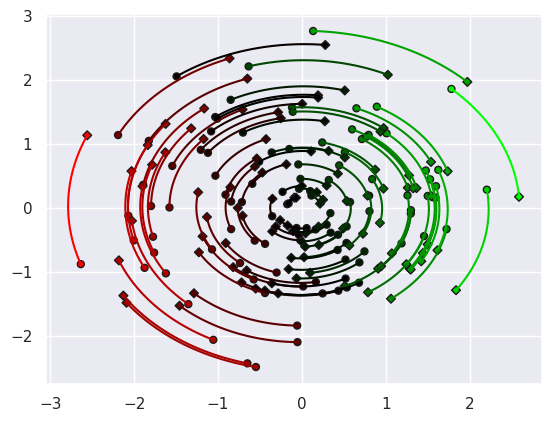

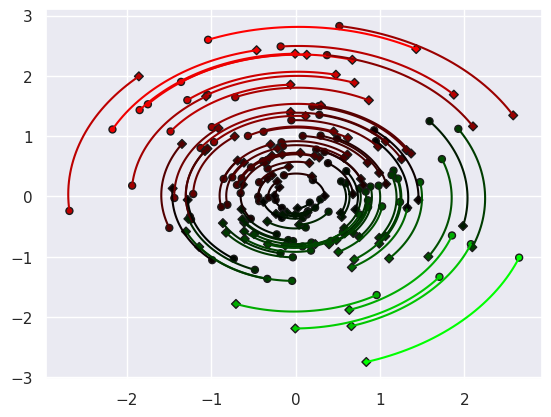

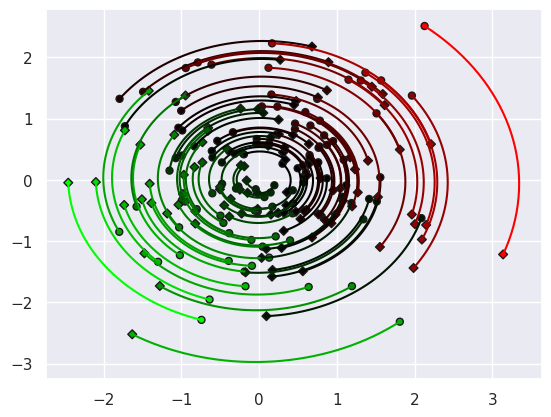

In [107]:

A_eigenvalues, A_eigenvectors  = np.linalg.eig(A)

imag_part = np.imag(A_eigenvalues)
sorted = np.argsort(imag_part)[::-1]
print(sorted)

for i in sorted[:3][::-1]:
    

    max_eigenvalue = A_eigenvalues[i]
    max_eigenvector = A_eigenvectors[:,i]

    row1 = np.real(max_eigenvector)
    row2 = np.imag(max_eigenvector)

    row1 = row1 / np.linalg.norm(row1)
    row2 = row2 / np.linalg.norm(row2)

    P = np.vstack((row1,row2))
    Z = Z.reshape((M,C*T))
    P_FR_Z_plane = P @ Z
    P_FR_Z_plane = P_FR_Z_plane.reshape((2,C,T))

    start = np.where(newtimes == -150)[0][0]
    end = np.where(newtimes == 200)[0][0] + 1
    movement_plane = P_FR_Z_plane[:,:,start:end]
    plot_data(movement_plane)



0 66
(2, 182)
(182, 7128)


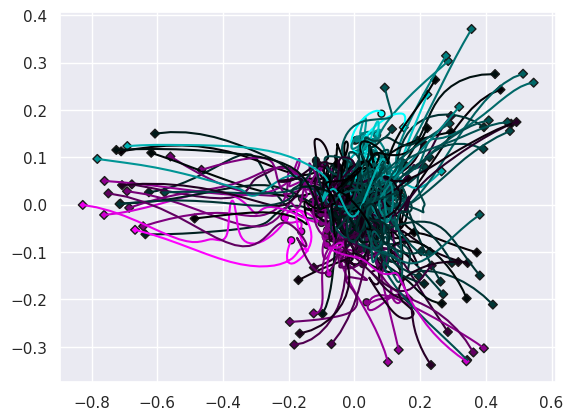

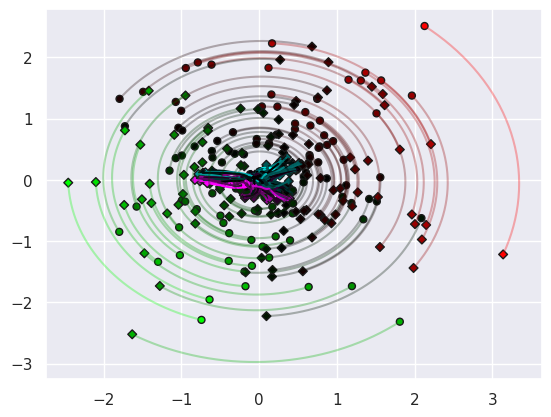

In [108]:
start = np.where(times == -800)[0][0]
end = np.where(times == -150)[0][0] + 1
T = end-start
print(start,end)
PFRVMT = ( P @ V_M.T ) 
print(PFRVMT.shape)
X_slice = X[:,:,start:end]
X_slice = X_slice.reshape((N,C*T))
print(X_slice.shape)
pre_movement_plane = PFRVMT @ X_slice
pre_movement_plane = pre_movement_plane.reshape((2,C,T))
plot_data(pre_movement_plane,alt_colours=True)
plot_data(pre_movement_plane,show=False,alt_colours=True,alpha=1)
plot_data(movement_plane,show=False,alt_colours=False,alpha=0.3)
plt.show()